# Tesco Creative Extension Project

## Table of Contents:
1. [Useful functions](#first-bullet)
    * [Housing](#house)
    * [Income](#income)
    * [Jobs](#jobs)
    * [Community](#community)
    * [Education](#education)
    * [Environment](#env)
    * [Civic Engagement](#civic)
    * [Health](#health)
    * [Life Satisfaction](#satisfaction)
    * [Safety](#safety)
    * [Work-Life Balance](#balance)
    * [Food](#food)
2. [data preprocessing](#second-bullet)

3. [PCA](#3-bullet)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## useful functions data preprocessing <a class="anchor" id="first-bullet"></a>
in this section we define useful functions to help us in our data preprocessing pipeline:

In [2]:
#Can choose between 'standardize' (xi - mean)/std or 're_scale' (rescales between 0 and 1), also can remove outliers or not
# must be a list though, if remove all outliers just [True] or [False], if some columns yes and others no : [True, False...]
# must match 'columns' lenght. (can be only 1 column) 

def normalize(df,method='standardize', remove_outliers = [True]):
    """function that will allow us to normalize the data, using different methods, and remove outliers (or not).  """
    data  = df.copy()
    start = 1
    if 'Names' in data.columns:
        start = 2
        
    if len(remove_outliers) == 1 :
        remove_outliers = remove_outliers*data.shape[1]
    elif len(remove_outliers) != data.shape[1] : print('Warning, remove_outliers size should match the one of colums')
        
    for i,col in enumerate(data.columns[start:]) :
        if remove_outliers[i] :
            #remove outliers
            data.loc[:,col] = data.loc[:,col].clip(lower = data.loc[:,col].quantile(0.025))
            data.loc[:,col] = data.loc[:,col].clip(upper = data.loc[:,col].quantile(0.975))
        if method == 'standardize' :
            data.loc[:,col] = (data.loc[:,col] - data.loc[:,col].mean())/data.loc[:,col].std()
        elif method == 're_scale' :
            data.loc[:,col] = ((data.loc[:,col] - data.loc[:,col].min()) / (data.loc[:,col].max() - data.loc[:,col].min()))
        else : print('Warning, unknown method ', method)
    return data

In [3]:
# It will happen that we want to inverse some fields in our data sets, to be consistent
def inverse(df, columns = []) :
    if not columns : #if no columns specified apply to all 
        columns =  df.columns[df.columns != 'area_id']
        if 'Names' in df.columns:
            columns = columns[columns != 'Names']
    else : columns = pd.Series(columns)
    for col in columns :
        df.loc[:,col] = 1 - df.loc[:,col]       

    return df

In [4]:
def import_converting_dataframes():
    """imports the area_level converting dataframes. returns reduced dataframes used to convert under dictionary format."""
    #names of the identified dataframes to convert
    ward_oa_2011 = pd.read_csv('data/convert/2011 _OA-Ward-LA.csv')
    oa_lsoa_2011 = pd.read_csv('data/convert/2011 _OA-LSOA-MSOA-LA.csv')
    lsoa_11_to_wd_19 = pd.read_csv('data/convert/Lower_Layer_Super_Output_Area__2011__to_Ward__2019__Lookup_in_England_and_Wales.csv')
    
    #keep only relevent columns
    ward_oa_2011 = ward_oa_2011[['OA11CD','Ward11CD']]
    oa_lsoa_2011 = oa_lsoa_2011[['OA11CD','LSOA11CD']]
    lsoa_11_to_wd_19 = lsoa_11_to_wd_19[['LSOA11CD','WD19CD']]
    
    return {'ward_to_oa_2011': ward_oa_2011,
           'oa_to_lsoa_2011': oa_lsoa_2011,
           'lsoa_11_to_ward_19': lsoa_11_to_wd_19}

In [5]:
def convert_ward_2011_to_ward_2019(df_2011,df_2019):
    """function that converts the dataframe containing 2011 data to dataframe containing 2019 area data.
    given two dataframes to convert, returns converted dataframe."""
    
    converters = import_converting_dataframes()
    conv_1 = converters['ward_to_oa_2011'].merge(df_2011, left_on='Ward11CD', right_on='area_id', how='inner')
    conv_2 = conv_1.merge(converters['oa_to_lsoa_2011'], on='OA11CD', how='inner')
    conv_3 = conv_2.merge(converters['lsoa_11_to_ward_19'], on='LSOA11CD')
    
    result = conv_3.merge(df_2019, left_on='WD19CD', right_on='area_id', how='inner')
    result = result.drop_duplicates(subset='area_id_y', ignore_index = True)
    
    #remove and rename converter columns
    result.drop(labels=['OA11CD','Ward11CD','LSOA11CD', 'WD19CD', 'area_id_x'],axis=1, inplace=True) 
    result.rename(columns={'area_id_y':'area_id'},inplace=True)
    
    #reorder to have area_id in first position
    first_column = result.pop('area_id')
    result.insert(0, 'area_id', first_column)
    
    return result

## Data Pre-processing <a class="anchor" id="second-bullet"></a>

In [6]:
#importing the correct data
ward_tesco = pd.read_csv('data/tesco/year_osward_grocery.csv')
ward_crime = pd.read_csv('data/crime_wards.csv', header=2)
ward_demographics = pd.read_csv('data/demographics_ward.csv', header=2)
ward_education = pd.read_csv('data/education_ward.csv', header=2)
ward_environment = pd.read_csv('data/environment_ward.csv', header=2)
ward_property = pd.read_csv('data/property_wards.csv', header=2)
ward_total_wellbeing = pd.read_csv('data/total_stats_ward.csv') #serves as validation set (Sort of)
validation = pd.read_csv('data/total_stats_scores_ward.csv', header = 1) #serves as validation set (Sort of)

In [7]:
#getting rid of all the badly formated data
ward_crime = ward_crime.dropna()
ward_demographics = ward_demographics.dropna(axis=1)
ward_education = ward_education.dropna()
ward_property= ward_property.dropna()

In [8]:
#rename all the "New Code " to "area id" for merging purposes
master_data = {'crime': ward_crime, 'demographics': ward_demographics, 'education': ward_education,
              'environment': ward_environment, 'property': ward_property, 'foods':ward_tesco}

for key in master_data:
    master_data[key].rename(columns= {"New Code":"area_id"}, inplace=True)

We need to create 11 different indicators + 1 with the food. here is the list :
* Housing
* Income
* Jobs
* Community
* Education
* Environment
* Civic Engagement
* Health
* Life Satisfaction
* Safety
* Work-Life Balance

**Housing**

<a class="anchor" id="house"></a>
To create our indicators we need our different categories.
**Housing** : 
- need average # of rooms shared per person --> gives an idea of how densly packed living conditions -- here called `people_per_sq_km` and we use a way of measuring what types of housing are in the wards : `detached_house`, `semi_detached_house`, `terraced_house` and `apartment`. We are working under the assumption that a house is larger than an apartment and therefore brings less density. 
- need an access to an indoor private flushing toilet --> this is not very pertinent to our dataset. 
- need way of measuring housing expenditure: --> we employ the median house price `median_house_price`


In [9]:
#we want to create a data set with only the latest data possible (since tesco is 2015) -- we use census data from 2011
column_names = ["area_id","Names",
                "Median House Price 2014",
                "Accomodation Type - 2011 Census Whole house or bungalow: Detached",
                "Accomodation Type - 2011 Census Whole house or bungalow: Semi-detached",
                "Accomodation Type - 2011 Census Whole house or bungalow: Terraced",
                "Accomodation Type - 2011 Census Flat, maisonette or apartment"]
housing = pd.DataFrame(data=ward_demographics, 
                       columns=column_names)

housing.rename(columns={"Median House Price 2014":"median_house_price",
                "Accomodation Type - 2011 Census Whole house or bungalow: Detached":"detached_house",
                "Accomodation Type - 2011 Census Whole house or bungalow: Semi-detached":"semi_detached_house",
                "Accomodation Type - 2011 Census Whole house or bungalow: Terraced":"terraced_house",
                "Accomodation Type - 2011 Census Flat, maisonette or apartment":"apartment"}, inplace=True)

In [10]:
housing = convert_ward_2011_to_ward_2019(housing,ward_tesco)

In [11]:
#keep only wanted rows
column_names = ["area_id","Names","median_house_price","people_per_sq_km","detached_house","semi_detached_house",
               "terraced_house","apartment"]
housing = pd.DataFrame(data=housing, columns=column_names)

In [12]:
#normalize the data by rescaling
housing = normalize(housing, 're_scale',remove_outliers = [True])

In [13]:
#we take the complement of certain values if a higher value indicates a negative influence.
#i.e a higher value for an unemployment rate indicates a "bad" factor. By taking the complement,
#we instead measure the employment rate 
housing = inverse(housing, ['people_per_sq_km'])

In [14]:
housing.head(3)

,area_id,Names,median_house_price,people_per_sq_km,detached_house,semi_detached_house,terraced_house,apartment
0,E05000029,Chadwell Heath,0.026023,0.902711,0.083816,0.432339,0.452393,0.151094
1,E05000042,Whalebone,0.020819,0.673518,0.093760,0.261514,0.762576,0.106365
2,E05000030,Eastbrook,0.025550,0.898288,0.066058,0.468402,0.666415,0.039612


**Income** <a class="anchor" id="income"></a>


link here : http://www.oecdbetterlifeindex.org/topics/income/ 
* income 
* household net wealth : average total wealth of household assets (savings, stocks) minus liabilites (loans)
* household net adjusted disposable income

Here we employ the median income of a ward : `median_income` to measure this

In [15]:
#code here
column_names = ['area_id', "Median Modelled Household income (£) 2012/13"]

income = pd.DataFrame(data=master_data["property"],columns=column_names)
income = convert_ward_2011_to_ward_2019(income,ward_tesco)

income = income[column_names]
income.rename(columns= {"Median Modelled Household income (£) 2012/13":"median_income"}, inplace=True)

In [16]:
#normalize the data by rescaling
income = normalize(income, 're_scale',remove_outliers = [True])

In [17]:
income.head(3) 

,area_id,median_income
0,E05000029,0.188386
1,E05000042,0.309643
2,E05000030,0.317826


**Jobs** <a class="anchor" id="jobs"></a>


link here : http://www.oecdbetterlifeindex.org/topics/jobs/
* job security -- expected loss of earnings when someone becomes unemployed : we use the number of incapacity benefit claimants per year to modelise this (`incapacity_claimants`) as well employment and support allowance (ESA) claimants (`esa_claimants`). ESA gives you: 
1. money to help with living costs if you’re unable to work
2. support to get back into work if you’re able to
3. You can apply for ESA if you’re employed, self-employed or unemployed.


* personal earnings 
* long-term unemployment rate (have been actively searching for a job in past 12 months) -- we use JSA claiment rates (`jsa_claimants`), which is short for Jobseekers allowance claim, you are eligible if you are actively seeking a job and are of pensionable age. 
* employment rate (`employment_rate_16-64`)

In [18]:
column_names = ['area_id', "Employment rate (16-64) 2011", "Incapacity Benefit Claimants 2014",
               "Employment and support allowance claimants 2014",
                "JSA Claimant Rate 2015"]
jobs = pd.DataFrame(data=master_data["property"],columns=column_names)
jobs = convert_ward_2011_to_ward_2019(jobs,ward_tesco)

jobs = jobs[column_names]
jobs.rename(columns= {"Employment rate (16-64) 2011":"employment_rate_16-64",
                     "Incapacity Benefit Claimants 2014":'incapacity_claimants',
               "Employment and support allowance claimants 2014": "esa_claimants",
                "JSA Claimant Rate 2015": "jsa_claimants"}, inplace=True)

In [19]:
#normalize the data by rescaling
jobs = normalize(jobs, 're_scale',remove_outliers = [True])

For `incapacity_claimants`, `jsa_claimants` and `esa_claimants`, we want want the data to be consistent with the `emplyoment_rate_16-64` field. The latter is better when high, so we will inverse the former to reflect the fact that more claimants for social programms is better.

In [20]:
jobs = inverse(jobs,['incapacity_claimants', 'jsa_claimants' ,'esa_claimants'])
jobs.head(3)

,area_id,employment_rate_16-64,incapacity_claimants,esa_claimants,jsa_claimants
0,E05000029,0.332421,0.602978,0.630611,0.336650
1,E05000042,0.490524,0.702233,0.745989,0.579878
2,E05000030,0.518901,0.702233,0.702722,0.270315


**Community** <a class="anchor" id="community"></a>


link here : http://www.oecdbetterlifeindex.org/topics/community/
* community
* quality of support network -- how much can you rely on friends --> we do not have the data required for this, so instead we are evaluating the richness of community diversity by 3 factors:

`diversity_ratio` -- which is a measure of the ethnical diversity in a ward. 

`religion_ratio` -- which is a measure of the religious diversity in a ward. 

`no_english_main_language` -- which counts the amount of households who do not have a english-speaker inside it.

In [21]:
column_names = ['area_id', "Ethnic Group 5 groups - 2011 Census White", "Ethnic Group 5 groups - 2011 Census Mixed", 
                "Ethnic Group 5 groups - 2011 Census Asian or Asian British", "Ethnic Group 5 groups - 2011 Census Black or Black British",
               "Ethnic Group 5 groups - 2011 Census Other",
               "Household Language - 2011 Census No people in household have English as a main language",
               "Religion - 2011 Census Christian","Religion - 2011 Census Buddhist","Religion - 2011 Census Hindu",
               "Religion - 2011 Census Jewish","Religion - 2011 Census Muslim","Religion - 2011 Census Sikh", 
               "Religion - 2011 Census Other religions",
                "Religion - 2011 Census No religion"]

community = pd.DataFrame(data=master_data["demographics"],columns=column_names)
community = convert_ward_2011_to_ward_2019(community,ward_tesco)
community = community[column_names]
community.rename(columns= {"Ethnic Group 5 groups - 2011 Census White":'white', "Ethnic Group 5 groups - 2011 Census Mixed":'mixed', 
                "Ethnic Group 5 groups - 2011 Census Asian or Asian British":'asian', 
                           "Ethnic Group 5 groups - 2011 Census Black or Black British":'black',
               "Ethnic Group 5 groups - 2011 Census Other":'other_ethnic',
               "Household Language - 2011 Census No people in household have English as a main language":'no_english_main_language',
               "Religion - 2011 Census Christian":'christian',"Religion - 2011 Census Buddhist":'buddhist',"Religion - 2011 Census Hindu":'hindu',
               "Religion - 2011 Census Jewish":'jewish',"Religion - 2011 Census Muslim":'muslim',"Religion - 2011 Census Sikh":'sikh', 
               "Religion - 2011 Census Other religions":'other',
                "Religion - 2011 Census No religion":'no_religion'},
                 inplace=True)

our diversity ratio is defined as white to all other races. Our religious diversity is defined as the christian and no religion stated to all other religions ratio.

In [22]:
community = community.assign(diversity_ratio = community['white']/
                             (community['mixed']+community['asian']+community['black']+community['other_ethnic']))
community = community.assign(religion_ratio = (community['christian']+community['no_religion'])/
                             (community['buddhist']+community['hindu']+community['jewish']+community['muslim']+
                             community['sikh']+community['other']))

In [23]:
 community = community[['area_id','no_english_main_language','diversity_ratio', 'religion_ratio']]

In [24]:
#normalize the data by rescaling
community = normalize(community, 're_scale',remove_outliers = [True])

#inverse the fiel 'no_english_main_language', as it is difficult to integrate in english society when no one in the household speaks english
community = inverse(community, ['no_english_main_language'])

In [25]:
community.head(3)

,area_id,no_english_main_language,diversity_ratio,religion_ratio
0,E05000029,0.873467,0.150177,0.193916
1,E05000042,0.819516,0.109385,0.149293
2,E05000030,0.931734,0.304819,0.549159


**Education** <a class="anchor" id="education"></a>

link here : http://www.oecdbetterlifeindex.org/topics/education/
* years in education -- modelised by unauthorised absences in school `unauthorised_school_abscence`
* student skills -- average performance of student here GCSE `GCSE_score`
* education attainment -- percent of people 24- 64 years old having at least an upper-secondary education `higher_education` 

to obtain the three points we do the following: years in education will be modelised by unauthorised absences in schools, the student skills will be how well the students performed on the GCSEs, and we also add the percent of higher education working people.

In [26]:
#code here
column_names = ['area_id', 'Average GCSE capped point scores 2014','Unauthorised Absence in All Schools (%) 2013',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Apprenticeship',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Level 3 qualifications',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Level 4 qualifications and above']
education = pd.DataFrame(data=master_data["education"],columns=[column_names[0],column_names[1], column_names[2]])
education_2 = pd.DataFrame(data=master_data["property"], columns=[column_names[0],column_names[3], 
                                                                  column_names[4], column_names[5]])
education = education.merge(education_2, on='area_id', how='inner')
education = convert_ward_2011_to_ward_2019(education,ward_tesco)
education = education[column_names]
education = education.assign(higher_education= education[column_names[3]]+
                             education[column_names[4]]+education[column_names[5]])
education.rename(columns= {'Average GCSE capped point scores 2014':"GCSE_score",
                          'Unauthorised Absence in All Schools (%) 2013': 'unauthorised_school_abscence'},
                 inplace=True)
education.drop(labels=[column_names[3],column_names[4], column_names[5]],axis=1, inplace=True)

In [27]:
#normalize the data by rescaling
education = normalize(education, 're_scale',remove_outliers = [True])

#unfortunately unauthorised school abscences don't allow for better grade, so we inverse this field 
education = inverse(education, ['unauthorised_school_abscence'])

In [28]:
education.head(3)

,area_id,GCSE_score,unauthorised_school_abscence,higher_education
0,E05000029,0.000000,0.150943,0.033077
1,E05000042,0.219512,0.528302,0.127584
2,E05000030,0.158537,0.452830,0.023627


**Environment** <a class="anchor" id="env"></a>


link here: http://www.oecdbetterlifeindex.org/topics/environment/
* water quality 
* air pollution -- measured in PM 2.5
* in addition : access to parks and greens 

Here, we do not have a way of measuring the water quality (from the dataset we found), so we are instead measuring other air pollution factors such as :
`PM10_mean` 
`NO2_mean`

additionally, we are assessing the environment quality by observing whether homes have an easy access to nature : `homes_without_access_nature_%` and counting how much of the area in a ward is a greenspace : `area_greenspace` 

In [29]:
#code here
column_names = ['area_id','Annual Mean of Particulate Matter (PM10) 2011','Annual Mean of Nitrogen Dioxide (NO2) 2011', '% area that is greenspace 2014',
               '% homes with deficiency in access to nature 2012']

environment = pd.DataFrame(data=master_data["environment"],columns=column_names)
environment = convert_ward_2011_to_ward_2019(environment,ward_tesco)
environment = environment[column_names]


environment.rename(columns= {'Annual Mean of Particulate Matter (PM10) 2011':"PM10_mean",
                          '% area that is greenspace 2014': 'area_greenspace_%',
                          '% homes with deficiency in access to nature 2012': 'homes_without_access_nature_%',
                            'Annual Mean of Nitrogen Dioxide (NO2) 2011': 'NO2_mean'},
                 inplace=True)

In [30]:
#normalize the data by rescaling
environment = normalize(environment, 're_scale',remove_outliers = [True])

# only having lots of greenspace is a positive factor, so we inverse the others
environment = inverse(environment, ['PM10_mean', 'NO2_mean', 'homes_without_access_nature_%'])


In [31]:
environment.head(3)

,area_id,PM10_mean,NO2_mean,area_greenspace_%,homes_without_access_nature_%
0,E05000029,0.882353,0.901099,0.803700,0.363363
1,E05000042,0.794118,0.813187,0.197134,0.019019
2,E05000030,0.941176,0.934066,0.718781,1.000000


**Civic Engagement** <a class="anchor" id="civic"></a>


link here : http://www.oecdbetterlifeindex.org/topics/civic-engagement/
* voter turnout in latest elections -- modelised by `election_turnout`
* stakeholder engagement for developing regulations -- might be hard to do


In [32]:
#code here
column_names = ['area_id', 'Turnout Borough election 2010' ]
civic = pd.DataFrame(data=master_data["environment"],columns=column_names)
civic = convert_ward_2011_to_ward_2019(civic,ward_tesco)
civic = civic[column_names]

civic.rename(columns={'Turnout Borough election 2010':'election_turnout'}, inplace=True)

In [33]:
#normalize the data by rescaling
civic = normalize(civic, 're_scale',remove_outliers = [True])

In [34]:
civic.head(3)

,area_id,election_turnout
0,E05000029,0.488171
1,E05000042,0.594584
2,E05000030,0.548979


**Health** <a class="anchor" id="health"></a>


link here: http://www.oecdbetterlifeindex.org/topics/health/
* life expectancy -- modeled by `life_expectancy`
* self-reported health (kind of hard) -- modeled by a survey to which people answered if they were in bad health : `people_with_bad_health_percent`

In [35]:
#code here
column_names = ['area_id', 'Life expectancy at birth (all persons) 2009-2013', 
                'General Health - 2011 Census % People with Bad or Very Bad Health' ]
health = pd.DataFrame(data=master_data["demographics"],columns=[column_names[0],column_names[1]])
health_2 = pd.DataFrame(data=master_data["environment"],columns=[column_names[0],column_names[2]])
health = health.merge(health_2, on='area_id', how='inner')
health = convert_ward_2011_to_ward_2019(health,ward_tesco)
health = health[column_names]

health.rename(columns={'Life expectancy at birth (all persons) 2009-2013':'life_expectancy',
                      'General Health - 2011 Census % People with Bad or Very Bad Health': 'people_with_bad_health_percent'}, 
              inplace=True)

In [36]:
#normalize the data by rescaling
health = normalize(health, 're_scale',remove_outliers = [True])

#We inverse the field people_with_bad_health_percent
health  = inverse(health,['people_with_bad_health_percent']) 

In [37]:
health.head(3)

,area_id,life_expectancy,people_with_bad_health_percent
0,E05000029,0.348837,0.16
1,E05000042,0.651163,0.54
2,E05000030,0.162791,0.34


**Life Satisfaction** <a class="anchor" id="satisfaction"></a>


link here: http://www.oecdbetterlifeindex.org/topics/life-satisfaction/
* life satisfaction -- how satisfied are you with your life ? -- modelised by the answer to that survey `how_satisfied_are_you_score`

In [38]:
#code here
column_names = ['area_id','Subjective well-being average score, 2011/12 and 2012/13']
life_satisfaction = pd.DataFrame(data=master_data["environment"],columns=column_names)
life_satisfaction = convert_ward_2011_to_ward_2019(life_satisfaction,ward_tesco)
life_satisfaction = life_satisfaction[column_names]
life_satisfaction.rename(columns={'Subjective well-being average score, 2011/12 and 2012/13':'how_satisfied_are_you_score'}, 
              inplace=True)

In [39]:
#normalize the data by rescaling
life_satisfaction = normalize(life_satisfaction, 're_scale',remove_outliers = [True])

In [40]:
life_satisfaction.head(3)

,area_id,how_satisfied_are_you_score
0,E05000029,0.020045
1,E05000042,0.554566
2,E05000030,0.732739


**Safety** <a class="anchor" id="safety"></a>


link here : http://www.oecdbetterlifeindex.org/topics/safety/
* homicide rate
* feeling safe walking alone at night (self reported) 

Here we use a couple of variables to modelise whether one is feeling safe walking alone at night. We include the counts of theft, robbery, burglary, sexual offence, violence against the person and arsenal rate to modelise this. There are found in the following variables:
`theft_incidents`
`robbery_incidents`
`sexual_offences_incidents`
`violence_against_person_incidents`
`aresenal_incidents`

we also use the `crime_rate` to modelise the homicide rate. 

To answer the question "do you feel safe walking alone at night" we keep the above criminal counts as different categories. We will later combine them if it is significant to do so. 

In [41]:
# code here
column_names = ['area_id', 'Drugs 2014/15', 'Theft and Handling 2014/15',
                'Burglary 2014/15', 'Robbery 2014/15', 'Sexual offences 2014/15', 'Violence against the person 2014/15',
                'Total crime rate 2014/15']
safety = pd.DataFrame(data=master_data["crime"],columns=column_names)
safety = convert_ward_2011_to_ward_2019(safety,ward_tesco)
safety = safety[column_names]

safety.rename(columns={'Total crime rate 2014/15':'crime_rate',
                      'Drugs 2014/15':'drugs', 'Theft and Handling 2014/15':'theft',
                       'Burglary 2014/15':'burglary', 'Robbery 2014/15':'robbery', 
                       'Sexual offences 2014/15':'sexual_offences', 
                       'Violence against the person 2014/15':'violence_against_person'}, 
              inplace=True)


In [42]:
#normalize the data by rescaling
safety = normalize(safety, 're_scale',remove_outliers = [True])

safety = inverse(safety)

In [43]:
safety.head(3)

,area_id,drugs,theft,burglary,robbery,sexual_offences,violence_against_person,crime_rate
0,E05000029,0.886077,0.925207,0.611597,0.796851,0.612486,0.728399,0.726357
1,E05000042,0.921130,0.893396,0.522819,0.715592,0.634983,0.765813,0.750124
2,E05000030,0.872932,0.944005,0.766958,0.827324,0.702475,0.717487,0.786739


**Work-Life Balance** <a class="anchor" id="balance"></a>


link here : http://www.oecdbetterlifeindex.org/topics/work-life-balance/ 
* Time devoted to leisure and personal care
* employees working long hours 

We model this by `part_time_employee_percent`

Here, we will employ the number of part-time employees. This can be used to model how much less time workers spend at work. 

In [44]:
#code here
column_names = ['area_id', 'Number of Part-time employees 2013', 'Total employees 2013']
work_life_balance = pd.DataFrame(data=master_data["environment"],columns=column_names)
work_life_balance = convert_ward_2011_to_ward_2019(work_life_balance,ward_tesco)
work_life_balance = work_life_balance[column_names]

In [45]:
work_life_balance = work_life_balance.assign(part_time_employee_percent = 
                                             100*work_life_balance[column_names[1]]/work_life_balance[column_names[2]])

work_life_balance.drop(labels=[column_names[1],column_names[2]],axis=1, inplace=True)                     

In [46]:
#normalize the data by rescaling
work_life_balance = normalize(work_life_balance, 're_scale',remove_outliers = [True])

In [47]:
work_life_balance.head(3)

,area_id,part_time_employee_percent
0,E05000029,0.824562
1,E05000042,0.514172
2,E05000030,0.131582


**Food** <a class="anchor" id="food"></a>

lastly, we take care of the **food** indicator. We employ the following categories:
- those are the same 8 categories employed in the tesco paper for validation of health outcomes :
1. `energy_tot` which corresponds to the total energy obtained on average
2. `energy_fat` -- the energy obtained from fat-containing foods
3. `energy_sugar` -- the energy obtained from sugar-rich foods
4. `energy_saturate` -- the energy obtaiend from saturated fat foods
5. `energy_protein` -- the energy obtained from protein-rich foods
6. `energy_carb` -- the energy obtained from carb-rich foods
7. `energy_fibre` -- the energy obtained from fiber-rich foods
8. `h_nutrients_calories_norm` -- the normalised food entropy 

- the additional categories of f_{category} which corresponds to the fraction of product type {category} purchased. We include : `f_beer`, `f_dairy`, `f_eggs`, `f_fish`, `f_fruit_veg`, `f_grains`, `f_meat_red`, `f_poultry`, `f_readymade`,  `f_soft_drinks`, `f_spirits`, `f_sweets`, `f_water`, `f_wine`

In [48]:
column_names = ['area_id','energy_tot','energy_fat','energy_saturate', 'energy_sugar','energy_protein','energy_carb',
                'energy_fibre','h_nutrients_calories_norm', 'f_beer', 'f_dairy', 'f_eggs', 'f_fish', 'f_fruit_veg',
                'f_grains', 'f_meat_red', 'f_poultry', 'f_readymade', 'f_soft_drinks', 
                'f_spirits', 'f_sweets', 'f_water', 'f_wine' ]
foods = pd.DataFrame(data=master_data["foods"],columns=column_names)

foods = foods.merge(jobs, on='area_id', how='inner') #to obtain the same size as the other dataframes
foods = foods[column_names]

In [49]:
foods.head(3)

,area_id,energy_tot,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,h_nutrients_calories_norm,f_beer,...,f_fruit_veg,f_grains,f_meat_red,f_poultry,f_readymade,f_soft_drinks,f_spirits,f_sweets,f_water,f_wine
0,E05000026,187.114757,85.399176,33.243489,43.864852,19.910240,77.527804,2.890336,0.660005,0.010727,...,0.254950,0.149915,0.043116,0.018481,0.058700,0.043738,0.004656,0.181254,0.042942,0.007917
1,E05000027,188.638145,87.602703,32.093215,42.057709,20.846778,75.801393,2.917849,0.663760,0.013555,...,0.257425,0.150883,0.050048,0.018555,0.072056,0.037547,0.005180,0.173620,0.041258,0.007355
2,E05000028,186.861792,82.946787,32.522242,42.761088,20.769647,78.648192,2.919193,0.667451,0.010115,...,0.238032,0.160413,0.053081,0.018831,0.066641,0.036828,0.003657,0.179634,0.043609,0.009281


In [50]:
#normalize the data by rescaling
foods = normalize(foods, 're_scale')

# We know from the paper that proteins, fibers and high food diversity is showing of better food consumption and
# correlates with less food related diseases. We can extrapolate this to inverse the appropiate catergories. 
# For instance we will want to inverse f_readymade, as it is usually high in fats, carbs and sugars, same goes for 
# f_softdrinks or f_sweets. We will also inverse all the alcohol categories

foods = inverse(foods, ['energy_fat','energy_saturate', 'energy_sugar','energy_carb', 'f_beer','f_grains', 
                        'f_readymade', 'f_soft_drinks', 'f_spirits', 'f_sweets', 'f_wine'])

In [51]:
foods.head(3)

,area_id,energy_tot,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,h_nutrients_calories_norm,f_beer,...,f_fruit_veg,f_grains,f_meat_red,f_poultry,f_readymade,f_soft_drinks,f_spirits,f_sweets,f_water,f_wine
0,E05000026,0.737681,0.239935,0.373181,0.327575,0.302430,0.282720,0.120813,0.192998,0.824825,...,0.261980,0.535087,0.393352,0.430181,0.713121,0.143226,0.323766,0.268185,0.888188,0.954121
1,E05000027,0.787672,0.063284,0.563068,0.459885,0.560979,0.361806,0.174368,0.279351,0.654844,...,0.281120,0.520456,0.601690,0.436349,0.478858,0.344362,0.197789,0.369176,0.823053,0.977339
2,E05000028,0.729379,0.436537,0.492244,0.408387,0.539685,0.231396,0.176983,0.364261,0.861618,...,0.131127,0.376439,0.692859,0.459410,0.573840,0.367736,0.564385,0.289607,0.914022,0.897846


Now, we store all these indicators in a dictionary to easily access them:

In [52]:
meta_data_indicators = {'Housing': housing, 'Income': income, 'Jobs': jobs, 'Community': community,
                       'Education': education, 'Environment': environment, 'Civic':civic,
                       'Health': health, 'Life_Satisfaction': life_satisfaction, 'Safety': safety,
                       'Work_Life_Balance': work_life_balance, 'Foods':foods}

In [53]:
#Now we need to figure out how to score each indicator 

In [54]:
for n,v in meta_data_indicators.items():
    print(n + ' ' +str(np.shape(v)))

Housing (632, 8)
Income (632, 2)
Jobs (632, 5)
Community (632, 4)
Education (631, 4)
Environment (632, 5)
Civic (632, 2)
Health (632, 3)
Life_Satisfaction (632, 2)
Safety (632, 8)
Work_Life_Balance (632, 2)
Foods (632, 23)


# PCA - Principal Component Analysis <a class="anchor" id="3-bullet"></a>

In [55]:
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

Let's first define a couple of functions that will be very useful

First a function to show heatmaps of correlation

In [56]:
def correlations_heatmap(df) :
    X = df.loc[:, df.columns != 'area_id']
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
    n = round(X.shape[1]/1.3)
    
    fig, ax = plt.subplots(figsize=(n,n))  
    sns.heatmap(X.corr(), annot=True, ax=ax, center = 0)
    plt.show()

Here a function to do principal component analysis (PCA) and then compute the weights of each indicator. This method allows us to see if the indicators are correlated, if they are they should receive a proportionnaly smaller weight, to avoid double counting.
The method is based on the approch described by 'Tools for Composite Indicators Building' page 56-57 and initially presented in 'Nicoletti G., Scarpetta S.,Boylaud O. (2000)


In [57]:
def calculate_weights(df):
    """The data frame needs to contain an id column called 'area id'. 
    Approch described by 'Tools for Composite Indicators Building' page 56-57 
    initially presented in 'Nicoletti G., Scarpetta S.,Boylaud O. (2000)'"""
    
    X = df.loc[:, df.columns != 'area_id']
    
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
        
    pca = PCA()
    X_transformed = pca.fit_transform(X)

    eigenvalues = pca.explained_variance_

    components = 0
    sum_variance = sum(eigenvalues)
    cum_variance = 0
    for eigenvalue in eigenvalues:    
        components+=1
        
        cum_variance += eigenvalue
        print("Component cumulative variance: {} %".format(100*cum_variance/sum_variance))
        
        if cum_variance/sum_variance > 0.95: #if more than 90% of the variance is explained by current components that's enough
            break
        
    expl_var_array = []
    for i in range(components):
        expl_var_array.append(sum(pca.components_[i]))
    print("Explained var {}".format(expl_var_array))
    print("Eigenvalues {}".format(eigenvalues))
    weights_matrix = [ [ 0 for i in range(components) ] for j in range(X.shape[1]) ]
    final_weights = []
    for j in range(X.shape[1]):        
        for i in range(components):
            component = pca.components_[i]
            
            weights_matrix[j][i] = component[j]*component[j]/eigenvalues[i]
        final_weights.append(max(weights_matrix[j]))
    weights_df = pd.DataFrame({'weights':final_weights}, index = X.columns)
    return weights_df

And finaly we will need a function to apply the weights to the values

In [58]:
def calculate_index_for_df(df, weights):
    data = df.loc[:, df.columns != 'area_id']
    if 'Names' in data.columns:
        data = data.loc[:, data.columns != 'Names']
        return df.loc[:,['area_id', 'Names']].assign(Index = data.apply(lambda x : sum(x * weights.weights), axis = 1))
    return pd.DataFrame({'area_id' : df.area_id, 'Index' : data.apply(lambda x : sum(x * weights.weights), axis = 1)})

We can now start computing the weights for each category of indicators. Let's start with housing, first we must see if they are correlated at all, if not it doesn't make sens to compute the weights by pca, we would either need to decide ourselves of each weight to give, according to what indicator we deem more important (or simply have equal weights for all of them)

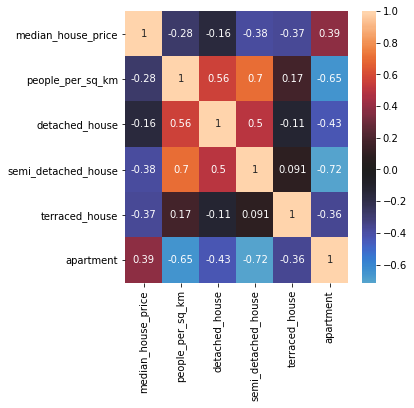

In [59]:
correlations_heatmap(housing)

In [60]:
housing_weights = calculate_weights(housing)

housing_index = calculate_index_for_df(housing,housing_weights )

# Create a df to store the indexes 
indexes = pd.DataFrame(housing_index)
indexes = indexes.rename(columns={'Index' : 'Housing'})

housing_weights

Component cumulative variance: 53.554187488292854 %
Component cumulative variance: 74.83700756753724 %
Component cumulative variance: 82.9048724985058 %
Component cumulative variance: 90.30190409276621 %
Component cumulative variance: 96.14976377663055 %
Explained var [-0.7837159040716247, 0.27250232789074813, 1.3784801545532068, 0.33994333576047564, -0.7849903300438]
Eigenvalues [0.21295316 0.08462912 0.0320811  0.0294136  0.02325346 0.0153101 ]


,weights
median_house_price,15.253691
people_per_sq_km,20.504379
detached_house,15.394386
semi_detached_house,4.572355
terraced_house,8.374931
apartment,13.972099


In [61]:
safety_weights = calculate_weights(safety)

safety_index = calculate_index_for_df(safety,safety_weights )

# Create a df to store the indexes 
indexes = pd.DataFrame(safety_index)
indexes = indexes.rename(columns={'Index' : 'Housing'})

safety_weights

Component cumulative variance: 72.21398163268829 %
Component cumulative variance: 81.86797534618566 %
Component cumulative variance: 89.15963597363452 %
Component cumulative variance: 93.71849352083902 %
Component cumulative variance: 97.35071498104244 %
Explained var [-2.6211866856007484, -0.2894178163414843, -0.008248564935925073, -0.0408610259123538, -0.18497398190918102]
Eigenvalues [0.27923898 0.03733032 0.02819559 0.01762831 0.01404517 0.00715462
 0.0030897 ]


,weights
drugs,40.380957
theft,10.174984
burglary,16.915446
robbery,30.711552
sexual_offences,18.734174
violence_against_person,2.392871
crime_rate,11.448049


In [62]:
health_weights = calculate_weights(health)

health_index = calculate_index_for_df(health,health_weights )

# Create a df to store the indexes 
indexes = pd.DataFrame(health_index)
indexes = indexes.rename(columns={'Index' : 'Housing'})

health_weights

Component cumulative variance: 79.64856274268458 %
Component cumulative variance: 100.0 %
Explained var [-1.4135358404784122, -0.04377702231752534]
Eigenvalues [0.09661496 0.02468661]


,weights
life_expectancy,19.000574
people_with_bad_health_percent,21.507211


In [63]:
housing

,area_id,Names,median_house_price,people_per_sq_km,detached_house,semi_detached_house,terraced_house,apartment
0,E05000029,Chadwell Heath,0.026023,0.902711,0.083816,0.432339,0.452393,0.151094
1,E05000042,Whalebone,0.020819,0.673518,0.093760,0.261514,0.762576,0.106365
2,E05000030,Eastbrook,0.025550,0.898288,0.066058,0.468402,0.666415,0.039612
3,E05000034,Heath,0.001894,0.757264,0.063927,0.293022,0.684286,0.185995
4,E05000040,Valence,0.001894,0.622356,0.093050,0.296438,0.911498,0.002169
...,...,...,...,...,...,...,...,...
627,E05000295,Kenton West,0.209570,0.727359,0.043328,0.848013,0.185610,0.000000
628,E05011241,Cranbrook,0.146196,0.770034,0.078133,0.410701,0.593656,0.115853
629,E05011239,Clayhall,0.167486,0.766014,0.189651,0.749314,0.437075,0.010640
630,E05000222,Greenwich West,0.224261,0.654245,0.079554,0.113466,0.565148,0.808126


Just from the weights we can already see some interesting things, having a detached house seems to be a big indicator of housing condition. It would make sense as individual houses in london are quite expensive. Median house price is also quite important, with a relatively high weight. It makes sense that the other housing options don't have such high weights, as they can be either in the center of london, where life quality is expected to be quite high, or in very poor suburbs, where we expect lower life quality. The high weigth of `detached_house` could be a problem, as it might overshadow the others, but we can see on the following graph that itst repartition is very much skewed to the left, meaning that only few areas have high density of detached houses. 

(array([249., 183.,  81.,  27.,  22.,  20.,   8.,   6.,  11.,  25.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

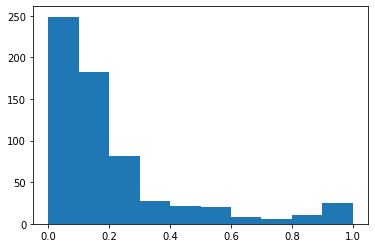

In [64]:
plt.hist(housing.detached_house)

Income, life satisaction, civic and work-life balance are all categories were we only have one sub-indicator, so no need to do any pca analysis. 

In [65]:
for cat in ['Income', 'Life_Satisfaction', 'Civic','Work_Life_Balance'] :
    indexes = indexes.merge(meta_data_indicators[cat],on='area_id', how='inner')
indexes =  indexes.rename(columns={'median_income' : 'Income', 'how_satisfied_are_you_score' : 'Life_Satisfaction', 
                                   'election_turnout' : 'Civic', 'part_time_employee_percent' : 'Work_Life_Balance' })


Jobs, community, education, environment and health  all have quite few sub-indicators, so we will perform pca on them, and add the indexes to `indexes`.

Heatmap of correlations for Jobs


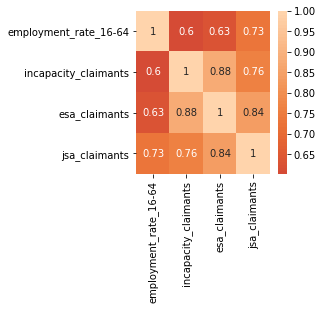

PCA for Jobs
Component cumulative variance: 81.14873463497986 %
Component cumulative variance: 92.28608570705748 %
Component cumulative variance: 97.4003606585798 %
Explained var [-1.992717446091142, -0.1492811656459252, -0.08075160660468461]
Eigenvalues [0.22336212 0.03065559 0.01407706 0.00715551]
                         weights
employment_rate_16-64  21.728195
incapacity_claimants   19.208966
esa_claimants           4.170992
jsa_claimants          41.659027
Heatmap of correlations for Community


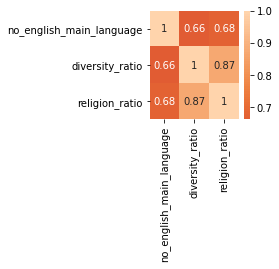

PCA for Community
Component cumulative variance: 81.79828588536506 %
Component cumulative variance: 96.06798659546338 %
Explained var [1.7281034579065433, 0.10508188497887466]
Eigenvalues [0.1575496  0.02748451 0.00757335]
                            weights
no_english_main_language  22.133966
diversity_ratio            7.063740
religion_ratio             7.186427
Heatmap of correlations for Education


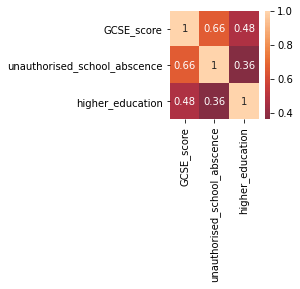

PCA for Education
Component cumulative variance: 66.38927051841407 %
Component cumulative variance: 89.90958547377365 %
Component cumulative variance: 100.0 %
Explained var [1.7297656504570513, -0.034024083009501216, 0.08217758985426127]
Eigenvalues [0.13257238 0.04696759 0.02014949]
                                weights
GCSE_score                    26.530549
unauthorised_school_abscence  22.023582
higher_education              13.499231
Heatmap of correlations for Environment


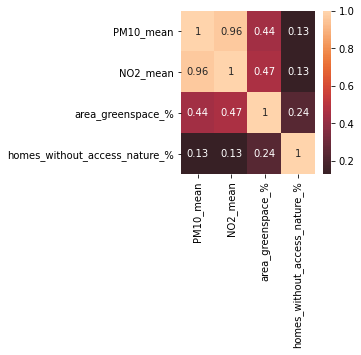

PCA for Environment
Component cumulative variance: 53.1988973130101 %
Component cumulative variance: 84.20643379898095 %
Component cumulative variance: 99.23238315570853 %
Explained var [-1.9711361723515528, -0.3324651903406274, 0.05845449037761283]
Eigenvalues [0.14647587 0.085375   0.04137189 0.00211353]
                                 weights
PM10_mean                       2.464010
NO2_mean                        2.262826
area_greenspace_%              18.610336
homes_without_access_nature_%   9.677746
Heatmap of correlations for Health


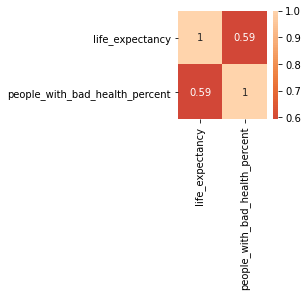

PCA for Health
Component cumulative variance: 79.64856274268458 %
Component cumulative variance: 100.0 %
Explained var [-1.4135358404784122, -0.04377702231752534]
Eigenvalues [0.09661496 0.02468661]
                                  weights
life_expectancy                 19.000574
people_with_bad_health_percent  21.507211


,area_id,Housing,Income,Life_Satisfaction,Civic,Work_Life_Balance,Jobs,Community,Education,Environment,Health
0,E05000029,10.069261,0.188386,0.020045,0.488171,0.824562,35.460279,21.787662,3.770833,22.686823,10.069261
1,E05000042,23.986361,0.309643,0.554566,0.594584,0.514172,51.416058,19.984682,19.181167,7.649605,23.986361
2,E05000030,10.405569,0.317826,0.732739,0.548979,0.131582,38.956077,26.722624,14.497948,27.487195,10.405569
3,E05000034,5.417856,0.092421,0.376392,0.393159,0.949066,25.418938,23.965505,12.929273,14.336998,5.417856
4,E05000040,2.209369,0.161605,0.376392,0.336152,0.824562,42.929984,22.526367,6.559747,10.188956,2.209369
...,...,...,...,...,...,...,...,...,...,...,...
627,E05000295,26.590685,0.355021,0.465479,0.666793,0.309213,67.724328,12.503332,32.385484,12.462406,26.590685
628,E05011241,18.044523,0.350930,0.732739,0.556580,0.703948,52.513238,13.795885,47.380249,22.778221,18.044523
629,E05011239,25.765586,0.468468,0.732739,0.758005,0.473686,64.286892,16.407487,22.901819,14.273523,25.765586
630,E05000222,23.206254,0.498968,0.821826,0.548979,0.595143,46.304028,16.472387,19.516117,25.157459,23.206254


In [67]:
for cat in ['Jobs','Community','Education', 'Environment', 'Health']:
    print('Heatmap of correlations for', cat)
    correlations_heatmap(meta_data_indicators[cat])
    print('PCA for', cat)
    weights = calculate_weights(meta_data_indicators[cat])
    index = calculate_index_for_df(meta_data_indicators[cat],weights )
    indexes = indexes.assign(new = index.Index)
    indexes =  indexes.rename(columns={'new' : cat})
    print(weights)
indexes

In [68]:
indexes.shape

(632, 11)

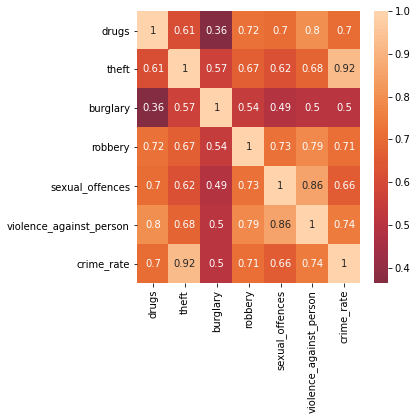

In [69]:
correlations_heatmap(safety)

In [70]:
safety_weights = calculate_weights(safety)
safety_index = calculate_index_for_df(safety, safety_weights)
indexes = indexes.assign(new = safety_index.Index)
indexes =  indexes.rename(columns={'new' : 'Safety'})
safety_weights

Component cumulative variance: 72.21398163268829 %
Component cumulative variance: 81.86797534618566 %
Component cumulative variance: 89.15963597363452 %
Component cumulative variance: 93.71849352083902 %
Component cumulative variance: 97.35071498104244 %
Explained var [-2.6211866856007484, -0.2894178163414843, -0.008248564935925073, -0.0408610259123538, -0.18497398190918102]
Eigenvalues [0.27923898 0.03733032 0.02819559 0.01762831 0.01404517 0.00715462
 0.0030897 ]


,weights
drugs,40.380957
theft,10.174984
burglary,16.915446
robbery,30.711552
sexual_offences,18.734174
violence_against_person,2.392871
crime_rate,11.448049


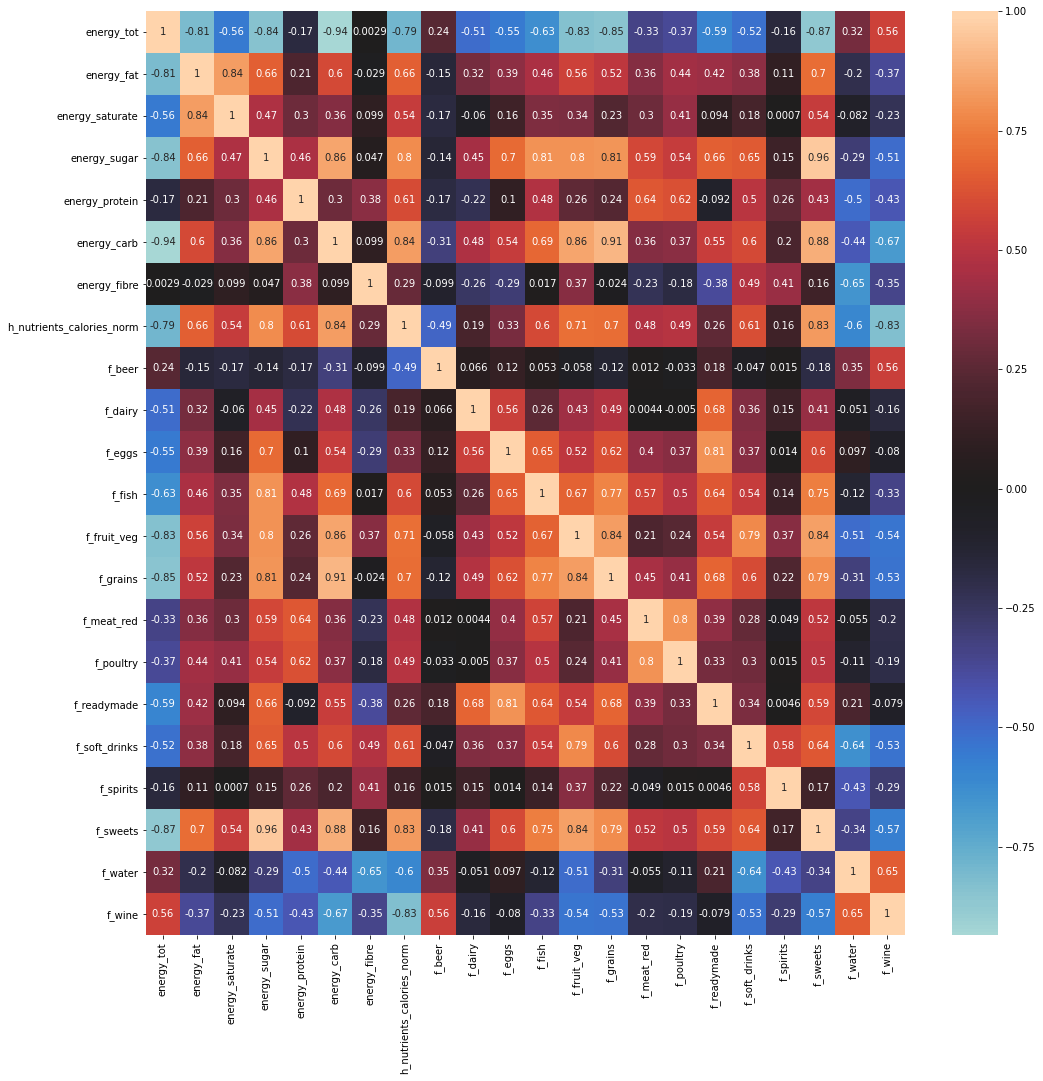

In [71]:
correlations_heatmap(foods)

In [72]:
foods_weights = calculate_weights(foods)
foods_index = calculate_index_for_df(foods, foods_weights)
indexes = indexes.assign(new = foods_index.Index)
indexes =  indexes.rename(columns={'new' : 'Foods'})
foods_weights

Component cumulative variance: 48.275552811215796 %
Component cumulative variance: 63.916961258838434 %
Component cumulative variance: 73.7684150902558 %
Component cumulative variance: 81.02957564731571 %
Component cumulative variance: 85.98953437804855 %
Component cumulative variance: 89.14019188260217 %
Component cumulative variance: 91.24685046247613 %
Component cumulative variance: 93.19913425504075 %
Component cumulative variance: 94.52897233608644 %
Component cumulative variance: 95.60612278950073 %
Explained var [-3.0150357229082063, -1.010682691320031, -0.5482026985225005, 1.8433266762898235, 1.4034216032849007, 0.1646754774222619, -0.28611976082505697, 0.623321680042295, -0.07219409693389123, 0.5396509521727486]
Eigenvalues [6.40886892e-01 2.07649070e-01 1.30783953e-01 9.63962575e-02
 6.58464243e-02 4.18268664e-02 2.79671550e-02 2.59177372e-02
 1.76543974e-02 1.42998177e-02 1.22888588e-02 1.16055110e-02
 1.05082734e-02 7.35115762e-03 5.22658866e-03 3.21003137e-03
 2.58189114e-

,weights
energy_tot,1.785248
energy_fat,2.828768
energy_saturate,4.703259
energy_sugar,1.370638
energy_protein,4.370041
energy_carb,1.987896
energy_fibre,6.321716
h_nutrients_calories_norm,1.011829
f_beer,6.580422
f_dairy,5.020411


In [73]:
indexes

,area_id,Housing,Income,Life_Satisfaction,Civic,Work_Life_Balance,Jobs,Community,Education,Environment,Health,Safety,Foods
0,E05000029,10.069261,0.188386,0.020045,0.488171,0.824562,35.460279,21.787662,3.770833,22.686823,10.069261,101.545342,70.064131
1,E05000042,23.986361,0.309643,0.554566,0.594584,0.514172,51.416058,19.984682,19.181167,7.649605,23.986361,99.422895,66.690237
2,E05000030,10.405569,0.317826,0.732739,0.548979,0.131582,38.956077,26.722624,14.497948,27.487195,10.405569,107.120663,73.519609
3,E05000034,5.417856,0.092421,0.376392,0.393159,0.949066,25.418938,23.965505,12.929273,14.336998,5.417856,95.989839,55.309910
4,E05000040,2.209369,0.161605,0.376392,0.336152,0.824562,42.929984,22.526367,6.559747,10.188956,2.209369,103.779087,69.256345
...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,E05000295,26.590685,0.355021,0.465479,0.666793,0.309213,67.724328,12.503332,32.385484,12.462406,26.590685,123.752155,56.038879
628,E05011241,18.044523,0.350930,0.732739,0.556580,0.703948,52.513238,13.795885,47.380249,22.778221,18.044523,81.631921,67.201805
629,E05011239,25.765586,0.468468,0.732739,0.758005,0.473686,64.286892,16.407487,22.901819,14.273523,25.765586,91.705583,58.826840
630,E05000222,23.206254,0.498968,0.821826,0.548979,0.595143,46.304028,16.472387,19.516117,25.157459,23.206254,63.365726,68.834227


In [74]:
indexes.isna().sum()


area_id              0
Housing              0
Income               0
Life_Satisfaction    0
Civic                0
Work_Life_Balance    2
Jobs                 0
Community            0
Education            1
Environment          0
Health               0
Safety               0
Foods                0
dtype: int64

In [75]:
indexes.Education = indexes.Education.fillna(indexes.Education.mean())
indexes.Work_Life_Balance = indexes.Work_Life_Balance.fillna(indexes.Work_Life_Balance.mean())
indexes.isna().sum()


area_id              0
Housing              0
Income               0
Life_Satisfaction    0
Civic                0
Work_Life_Balance    0
Jobs                 0
Community            0
Education            0
Environment          0
Health               0
Safety               0
Foods                0
dtype: int64

In [76]:
indexes = normalize(indexes, 'standardize', remove_outliers = [True])
indexes

,area_id,Housing,Income,Life_Satisfaction,Civic,Work_Life_Balance,Jobs,Community,Education,Environment,Health,Safety,Foods
0,E05000029,-1.215031,-0.758104,-1.751599,-0.085876,1.441045,-0.704995,0.638816,-1.844255,0.890798,-1.215031,0.395341,-0.245615
1,E05000042,0.379302,-0.276140,0.219813,0.341376,0.136169,0.085864,0.432489,-0.780239,-1.411477,0.379302,0.309456,-0.508986
2,E05000030,-1.176503,-0.243615,0.876951,0.158268,-1.472233,-0.531723,1.203556,-1.142525,1.625760,-1.176503,0.620946,0.024125
3,E05000034,-1.747892,-1.139536,-0.437324,-0.467350,1.964460,-1.202701,0.888041,-1.263875,-0.387603,-1.747892,0.170538,-1.397350
4,E05000040,-1.876864,-0.864550,-0.437324,-0.696235,1.441045,-0.334754,0.723351,-1.756612,-1.022690,-1.876864,0.485729,-0.308672
...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,E05000295,0.677651,-0.095773,-0.108755,0.631297,-0.725475,0.894194,-0.423651,0.241226,-0.674613,0.677651,1.293938,-1.340446
628,E05011241,-0.301391,-0.112035,0.876951,0.188786,0.933987,0.140246,-0.275736,1.401197,0.904792,-0.301391,-0.410455,-0.469052
629,E05011239,0.583129,0.355145,0.876951,0.997513,-0.034032,0.723815,0.023127,-0.492415,-0.397322,0.583129,-0.002824,-1.122814
630,E05000222,0.289933,0.476375,1.205519,0.158268,0.476572,-0.167517,0.030554,-0.754328,1.269065,0.289933,-1.149595,-0.341623


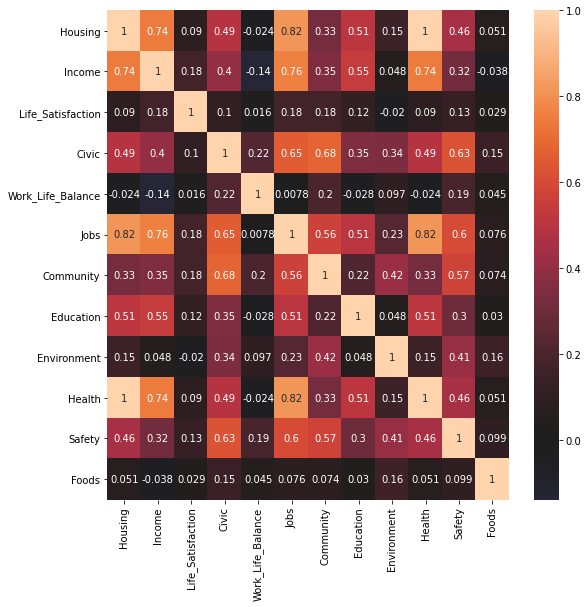

In [77]:
correlations_heatmap(indexes)

In [78]:
indexes_weigths = calculate_weights(indexes)
#indexes_weigths.weights.loc['Foods'] = 2.
final = calculate_index_for_df(indexes, indexes_weigths)
final


Component cumulative variance: 41.826638736884256 %
Component cumulative variance: 56.51723308646524 %
Component cumulative variance: 65.07276306346562 %
Component cumulative variance: 73.2179702617884 %
Component cumulative variance: 80.57085461619997 %
Component cumulative variance: 85.8005441101227 %
Component cumulative variance: 90.68029099516191 %
Component cumulative variance: 94.44469545586098 %
Component cumulative variance: 96.96202411615221 %
Explained var [3.079932802442379, -0.9127782259627704, 0.3840026454074525, -0.7704389938136653, -0.628346508139138, 0.09693347803940888, 0.645277258586736, 0.26633684055652956, 0.14473114418947802]
Eigenvalues [5.01919665e+00 1.76287132e+00 1.02666360e+00 9.77424864e-01
 8.82346123e-01 6.27562739e-01 5.85569626e-01 4.51728535e-01
 3.02079439e-01 2.27115709e-01 1.37441397e-01 3.66774620e-31]


,area_id,Index
0,E05000029,-2.124746
1,E05000042,-1.009305
2,E05000030,0.513841
3,E05000034,-3.231257
4,E05000040,-3.736640
...,...,...
627,E05000295,1.214759
628,E05011241,2.650615
629,E05011239,0.953532
630,E05000222,-0.051711


In [79]:
indexes_weigths

,weights
Housing,0.149466
Income,0.602192
Life_Satisfaction,0.632027
Civic,1.615862
Work_Life_Balance,0.615778
Jobs,0.034230
Community,0.337215
Education,1.181716
Environment,0.742855
Health,0.149466


In [80]:
final.to_csv('final.csv', index=False)
final


,area_id,Index
0,E05000029,-2.124746
1,E05000042,-1.009305
2,E05000030,0.513841
3,E05000034,-3.231257
4,E05000040,-3.736640
...,...,...
627,E05000295,1.214759
628,E05011241,2.650615
629,E05011239,0.953532
630,E05000222,-0.051711


In [81]:
ward_total_wellbeing.columns.values

array(['Old Ward Code', 'New ward code', 'Ward', 'Borough',
       'Life Expectancy 2005-2009', 'Life Expectancy 2006-2010',
       'Life Expectancy 2007-11', 'Life Expectancy 2008-12',
       'Life Expectancy 2009-13', 'Childhood Obesity 2009',
       'Childhood Obesity 2010', 'Childhood Obesity 2011',
       'Childhood Obesity 2012', 'Childhood Obesity 2013',
       'Incapacity Benefit rate - 2009', 'Incapacity Benefit rate - 2010',
       'Incapacity Benefit rate - 2011', 'Incapacity Benefit rate - 2012',
       'Incapacity Benefit rate - 2013', 'Unemployment rate 2009',
       'Unemployment rate 2010', 'Unemployment rate 2011',
       'Unemployment rate 2012', 'Unemployment rate 2013',
       'Crime rate - 2009', 'Crime rate - 2010', 'Crime rate - 2011',
       'Crime rate - 2012', 'Crime rate - 2013',
       'Deliberate Fires - 2009', 'Deliberate Fires - 2010',
       'Deliberate Fires - 2011', 'Deliberate Fires - 2012',
       'Deliberate Fires - 2013', 'GCSE point scores - 2009'

In [82]:
ward_total_wellbeing = ward_total_wellbeing.dropna()
ward_total_wellbeing

,Old Ward Code,New ward code,Ward,Borough,Life Expectancy 2005-2009,Life Expectancy 2006-2010,Life Expectancy 2007-11,Life Expectancy 2008-12,Life Expectancy 2009-13,Childhood Obesity 2009,...,"Homes with access to open space & nature, and % greenspace - 2009","Homes with access to open space & nature, and % greenspace - 2010","Homes with access to open space & nature, and % greenspace - 2011","Homes with access to open space & nature, and % greenspace - 2012","Homes with access to open space & nature, and % greenspace - 2013","Subjective well-being average score, 2011/12 and 2012/13","Subjective well-being average score, 2011/12 and 2012/13.1","Subjective well-being average score, 2011/12 and 2012/13.2","Subjective well-being average score, 2011/12 and 2012/13.3","Subjective well-being average score, 2013"
1,00AA,E09000001,City of London,City of London,84.3,83.7,83.7,84.5,86.4,22.2,...,-6.5,-6.5,-6.5,-6.5,-6.5,7.6,7.6,7.6,7.6,7.7
2,00ABFX,E05000026,Abbey,Barking and Dagenham,82.1,82.5,82.1,81.1,82.0,21.7,...,-0.9,-0.9,-0.9,-0.9,-0.9,7.9,7.9,7.9,7.9,7.8
3,00ABFY,E05000027,Alibon,Barking and Dagenham,77.8,78.3,78.3,78.1,79.0,26.0,...,-1.8,-1.8,-1.8,-1.8,-1.8,7.4,7.4,7.4,7.4,7.6
4,00ABFZ,E05000028,Becontree,Barking and Dagenham,78.4,78.9,78.7,79.0,79.2,22.4,...,-5.5,-5.5,-5.5,-5.5,-5.5,7.6,7.6,7.6,7.6,7.6
5,00ABGA,E05000029,Chadwell Heath,Barking and Dagenham,79.9,79.7,80.3,80.1,80.8,23.8,...,2.0,2.0,2.0,2.0,2.0,7.1,7.1,7.1,7.1,7.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,00BF,E09000029,SUTTON,Sutton,81.0,81.3,81.6,81.9,82.2,18.1,...,-0.5,-0.5,-0.5,-0.5,-0.5,7.9,7.9,7.9,7.9,7.8
656,00BG,E09000030,TOWER HAMLETS,Tower Hamlets,77.8,78.0,78.5,78.9,79.6,25.8,...,0.1,0.1,0.1,0.1,0.1,7.8,7.8,7.8,7.8,8.0
657,00BH,E09000031,WALTHAM FOREST,Waltham Forest,79.4,79.8,80.6,81.0,81.4,20.6,...,6.7,6.7,6.7,6.7,6.7,7.7,7.7,7.7,7.7,7.8
658,00BJ,E09000032,WANDSWORTH,Wandsworth,79.6,80.2,80.5,80.9,81.2,19.9,...,-1.4,-1.4,-1.4,-1.4,-1.4,7.5,7.5,7.5,7.5,7.7


In [83]:
merged_well_being = ward_total_wellbeing.set_index('New ward code').join(final.set_index('area_id'))

In [84]:
merged_well_being

,Old Ward Code,Ward,Borough,Life Expectancy 2005-2009,Life Expectancy 2006-2010,Life Expectancy 2007-11,Life Expectancy 2008-12,Life Expectancy 2009-13,Childhood Obesity 2009,Childhood Obesity 2010,...,"Homes with access to open space & nature, and % greenspace - 2010","Homes with access to open space & nature, and % greenspace - 2011","Homes with access to open space & nature, and % greenspace - 2012","Homes with access to open space & nature, and % greenspace - 2013","Subjective well-being average score, 2011/12 and 2012/13","Subjective well-being average score, 2011/12 and 2012/13.1","Subjective well-being average score, 2011/12 and 2012/13.2","Subjective well-being average score, 2011/12 and 2012/13.3","Subjective well-being average score, 2013",Index
New ward code,,,,,,,,,,,,,,,,,,,,,
E09000001,00AA,City of London,City of London,84.3,83.7,83.7,84.5,86.4,22.2,22.2,...,-6.5,-6.5,-6.5,-6.5,7.6,7.6,7.6,7.6,7.7,NaN
E05000026,00ABFX,Abbey,Barking and Dagenham,82.1,82.5,82.1,81.1,82.0,21.7,21.7,...,-0.9,-0.9,-0.9,-0.9,7.9,7.9,7.9,7.9,7.8,-3.722621
E05000027,00ABFY,Alibon,Barking and Dagenham,77.8,78.3,78.3,78.1,79.0,26.0,26.0,...,-1.8,-1.8,-1.8,-1.8,7.4,7.4,7.4,7.4,7.6,-2.720297
E05000028,00ABFZ,Becontree,Barking and Dagenham,78.4,78.9,78.7,79.0,79.2,22.4,22.4,...,-5.5,-5.5,-5.5,-5.5,7.6,7.6,7.6,7.6,7.6,-2.146133
E05000029,00ABGA,Chadwell Heath,Barking and Dagenham,79.9,79.7,80.3,80.1,80.8,23.8,23.8,...,2.0,2.0,2.0,2.0,7.1,7.1,7.1,7.1,7.6,-2.124746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E09000029,00BF,SUTTON,Sutton,81.0,81.3,81.6,81.9,82.2,18.1,18.1,...,-0.5,-0.5,-0.5,-0.5,7.9,7.9,7.9,7.9,7.8,NaN
E09000030,00BG,TOWER HAMLETS,Tower Hamlets,77.8,78.0,78.5,78.9,79.6,25.8,25.8,...,0.1,0.1,0.1,0.1,7.8,7.8,7.8,7.8,8.0,NaN
E09000031,00BH,WALTHAM FOREST,Waltham Forest,79.4,79.8,80.6,81.0,81.4,20.6,20.6,...,6.7,6.7,6.7,6.7,7.7,7.7,7.7,7.7,7.8,NaN


In [86]:
#validation = validation.dropna()
validation

,Old Ward Code,New ward code,Ward name,Borough,2009,2010,2011,2012,2013,2009.1,...,2009.11,2010.11,2011.11,2012.11,2013.11,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68
0,00AA,E09000001,City of London,City of London,18.8,14.9,13.7,16.0,23.7,-7.2,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,00ABFX,E05000026,Abbey,Barking and Dagenham,9.1,9.6,6.9,1.4,4.3,-6.1,...,8.1,8.1,8.1,8.1,6.1,NaN,NaN,NaN,NaN,NaN
2,00ABFY,E05000027,Alibon,Barking and Dagenham,-9.1,-8.5,-9.7,-11.5,-9.0,-14.8,...,-8.8,-8.8,-8.8,-8.8,-4.7,NaN,NaN,NaN,NaN,NaN
3,00ABFZ,E05000028,Becontree,Barking and Dagenham,-6.5,-5.7,-7.9,-7.7,-8.0,-7.6,...,-1.0,-1.0,-1.0,-1.0,-4.8,NaN,NaN,NaN,NaN,NaN
4,00ABGA,E05000029,Chadwell Heath,Barking and Dagenham,-0.3,-2.1,-0.9,-3.2,-1.2,-10.4,...,-16.7,-16.7,-16.7,-16.7,-4.8,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
#correlations_heatmap(merged_well_being)

In [89]:
print("Correlation scores with each column of well-being data:")
merged_well_being.corr()['Index']

Correlation scores with each column of well-being data:


Life Expectancy 2006-2010                                            0.532048
Life Expectancy 2007-11                                              0.528569
Life Expectancy 2008-12                                              0.525956
Life Expectancy 2009-13                                              0.521785
Childhood Obesity 2010                                              -0.733225
Childhood Obesity 2011                                              -0.733225
Childhood Obesity 2012                                              -0.719269
Childhood Obesity 2013                                              -0.716264
Incapacity Benefit rate - 2010                                      -0.625890
Incapacity Benefit rate - 2011                                      -0.613114
Incapacity Benefit rate - 2012                                      -0.605632
Incapacity Benefit rate - 2013                                      -0.582807
Unemployment rate 2010                                          

In [90]:
merged_val = validation.set_index('New ward code').join(final.set_index('area_id'))

In [91]:
merged_val

,Old Ward Code,Ward name,Borough,2009,2010,2011,2012,2013,2009.1,2010.1,...,2010.11,2011.11,2012.11,2013.11,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Index
E05000026,00ABFX,Abbey,Barking and Dagenham,9.1,9.6,6.9,1.4,4.3,-6.1,-6.1,...,8.1,8.1,8.1,6.1,NaN,NaN,NaN,NaN,NaN,-3.722621
E05000027,00ABFY,Alibon,Barking and Dagenham,-9.1,-8.5,-9.7,-11.5,-9.0,-14.8,-14.8,...,-8.8,-8.8,-8.8,-4.7,NaN,NaN,NaN,NaN,NaN,-2.720297
E05000028,00ABFZ,Becontree,Barking and Dagenham,-6.5,-5.7,-7.9,-7.7,-8.0,-7.6,-7.6,...,-1.0,-1.0,-1.0,-4.8,NaN,NaN,NaN,NaN,NaN,-2.146133
E05000029,00ABGA,Chadwell Heath,Barking and Dagenham,-0.3,-2.1,-0.9,-3.2,-1.2,-10.4,-10.4,...,-16.7,-16.7,-16.7,-4.8,NaN,NaN,NaN,NaN,NaN,-2.124746
E05000030,00ABGB,Eastbrook,Barking and Dagenham,-10.6,-9.4,-10.2,-8.0,-8.1,-9.0,-9.0,...,7.8,7.8,7.8,-4.7,NaN,NaN,NaN,NaN,NaN,0.513841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
#correlations_heatmap(merged_val)

In [94]:
print("Correlation scores with each column of validation data:")
merged_val.corr()['Index']

Correlation scores with each column of validation data:


2010           0.531339
2011           0.528276
2012           0.526062
2013           0.521837
2010.1         0.733058
2011.1         0.733058
2012.1         0.719516
2013.1         0.716329
2010.2         0.626258
2011.2         0.613058
2012.2         0.604579
2013.2         0.582427
2010.3         0.726338
2011.3         0.729025
2012.3         0.708875
2013.3         0.709007
2010.4         0.541046
2011.4         0.534593
2012.4         0.511336
2013.4         0.538131
2010.5         0.265978
2011.5         0.264020
2012.5         0.238137
2013.5         0.230950
2010.6         0.604993
2011.6         0.627201
2012.6         0.643740
2013.6         0.611688
2010.7         0.597296
2011.7         0.639558
2012.7         0.649547
2013.7         0.642184
2010.8         0.763456
2011.8         0.763378
2012.8         0.758359
2013.8         0.736193
2010.9        -0.497311
2011.9        -0.501412
2012.9        -0.503675
2013.9        -0.492352
2010.10        0.136708
2011.10        0